In [2]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub 

from tensorflow import keras 
from keras import layers 
from keras.models import Sequential

import requests
import imutils
import urllib


In [3]:
PATH = '/Users/theholygrail/lbp-project'
print(PATH)
train_dir = os.path.join(PATH, 'dataset')
validation_dir = os.path.join(PATH, 'dataset')

BATCH_SIZE = 32
IMG_SIZE = (478, 848)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.4,  # 40% of the dataset will be used for validation
    subset="training",  # Use the subset for training
    shuffle=True,
    seed=123,  # Provide a seed for consistent splitting
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

/Users/theholygrail/lbp-project
Found 12733 files belonging to 2 classes.
Using 7640 files for training.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 validation_split=0.2, 
                                                                 subset="validation",
                                                                 seed=12,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 12733 files belonging to 2 classes.
Using 2546 files for validation.


['not_visible', 'visible']


2024-04-19 14:01:39.213085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


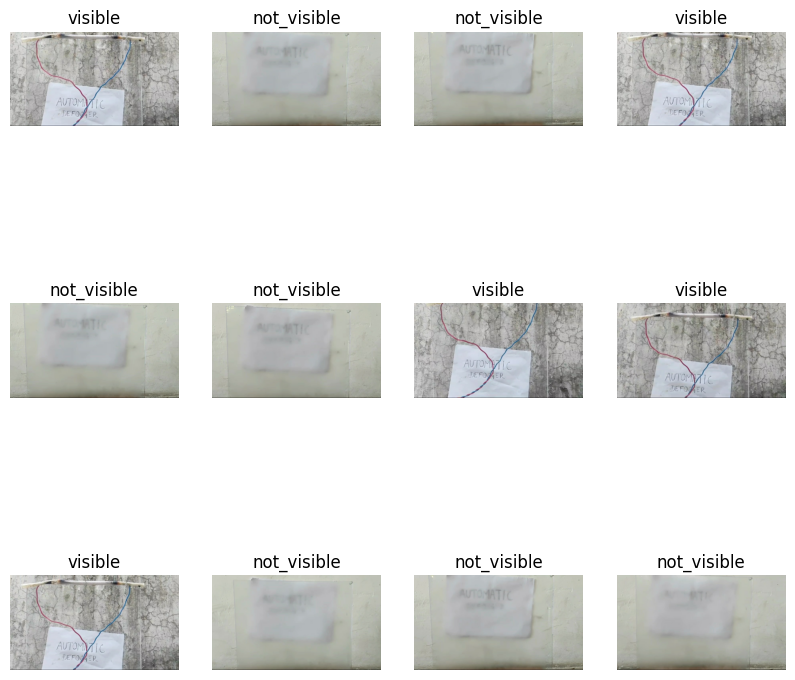

In [5]:
class_names = train_dataset.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


In [47]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))

Number of validation batches: 64
Number of test batches: 16
Number of train batches: 239


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
print(AUTOTUNE)
print(tf.data.AUTOTUNE)

Number of validation batches: 64
Number of test batches: 16
-1
-1


In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

2024-04-19 14:02:05.106168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


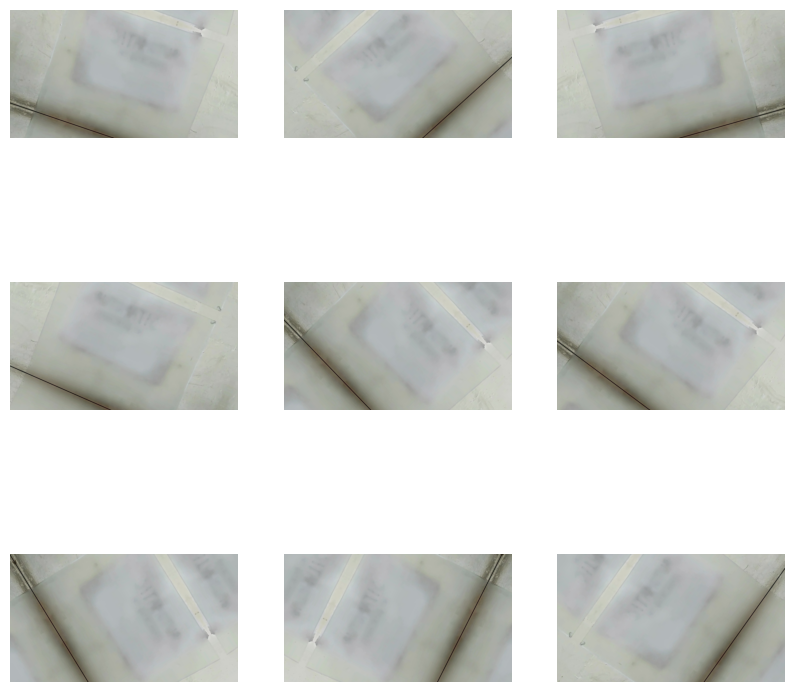

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [30]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [31]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
print(IMG_SHAPE)

/var/folders/00/3d5pbcqd24n9bh1ctktwjw2r0000gn/T/ipykernel_10627/3513509274.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,


(478, 848, 3)


In [32]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 15, 27, 1280)


In [33]:
base_model.trainable = False

In [34]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [35]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [49]:
inputs = tf.keras.Input(shape=(478, 848, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [50]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 478, 848, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 478, 848, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 478, 848, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 478, 848, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 15, 27, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [38]:
len(model.trainable_variables)

2

In [51]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]
)

In [53]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

64/64 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8162 - loss: 0.4905


In [54]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.49
initial accuracy: 0.82


In [55]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset) 

Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.8172 - loss: 0.4317 - val_accuracy: 0.8201 - val_loss: 0.2983
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - accuracy: 0.8477 - loss: 0.2683 - val_accuracy: 0.8545 - val_loss: 0.2427
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.9182 - loss: 0.2088 - val_accuracy: 0.9405 - val_loss: 0.2036
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.9585 - loss: 0.1653 - val_accuracy: 0.9621 - val_loss: 0.1702
Epoch 5/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.9722 - loss: 0.1361 - val_accuracy: 0.9676 - val_loss: 0.1502
Epoch 6/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.9757 - loss: 0.1178 - val_accuracy: 0.9671 - val_loss: 0.1361
Epoch 7/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.9760 - loss: 0.1049 - val_accuracy: 0.9700 - val_loss: 0.1254
Epoch 8/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.9783 - loss: 0.0913 - val_accu

In [56]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

16/16 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - accuracy: 0.9784 - loss: 0.0898
Test Loss: 0.09357393532991409
Test Accuracy: 0.982421875


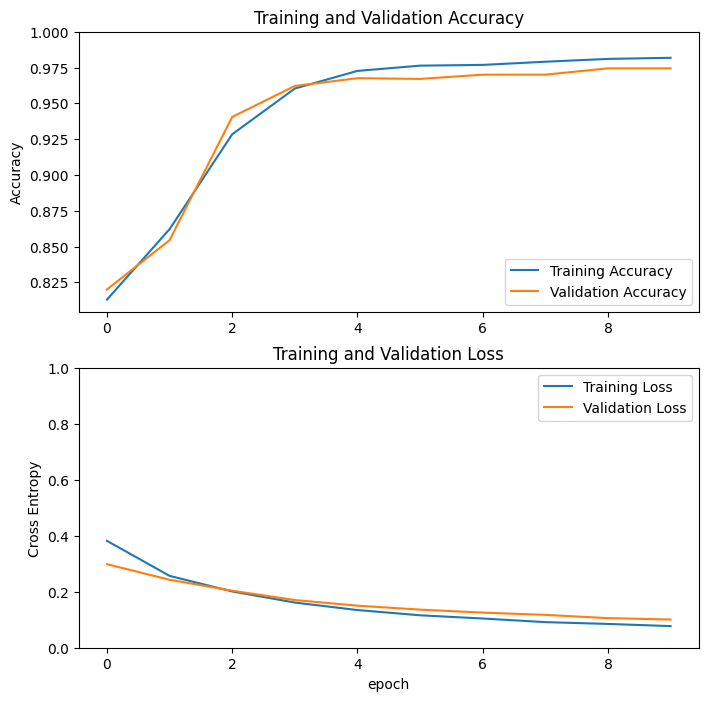

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [11]:
model = tf.keras.models.load_model("./visibility.keras")

In [ ]:
# url = "http://10.81.56.47:8080/video"
# capture = cv2.VideoCapture(url)

# while True:
#     _, frame = capture.read()
#     cv2.imshow("Android_cam", frame)
#     if cv2.waitKey(1) == ord("q"):
#         break
    
# capture.release()
# cv2.destroyAllWindows()

tf.Tensor(
[0.50116605 0.68180376 0.5009108  0.5580377  0.50307906 0.5011363
 0.50234836 0.6891743  0.50389713 0.5011066  0.5251057  0.5011148
 0.5007182  0.503128   0.50515753 0.6548529  0.50113285 0.5015255
 0.50757456 0.5066568  0.51029646 0.6591428  0.50865394 0.5027448
 0.5008606  0.50117683 0.5007478  0.501102   0.5006905  0.7133795
 0.71020275 0.51078135], shape=(32,), dtype=float32)
Predictions:
 [0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1]
Labels:
 [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
32


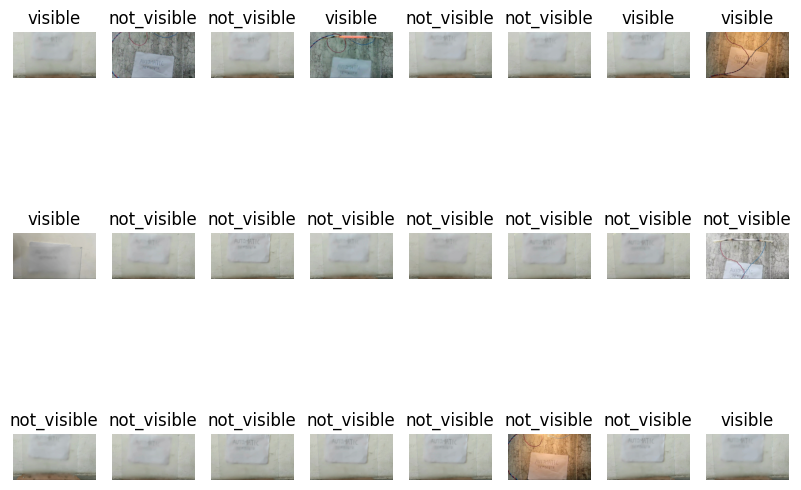

In [14]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
print(predictions)
predictions = tf.where(predictions < 0.51, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
print(len(label_batch))
plt.figure(figsize=(10, 10))
for i in range(24):
  ax = plt.subplot(4, 8, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[labels[i]])
  plt.axis("off")

In [ ]:
url = "http://10.81.56.47:8080/video"
capture = cv2.VideoCapture(url)

while True:
    _, frame = capture.read()

    resized_frame = cv2.resize(frame, (160, 160))  # Resize to match the input size expected by the model
    resized_frame = np.expand_dims(resized_frame, axis=0)  # Add batch dimension
    resized_frame = resized_frame / 255.0  # Normalize pixel value

# Add batch dimension
    # image = np.expand_dims(resized_frame, axis=0)

# Make prediction
    predictions = model.predict(resized_frame).flatten()

    # Interpret predictions
    predicted_class = class_names[np.argmax(predictions[0])] 
    
    cv2.rectangle(frame, (10, 10), (300, 50), (0, 0, 0), -1)  # Draw filled black rectangle as background

    # Draw label on frame
    cv2.putText(frame, predicted_class, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow("Android_cam", frame)
    if cv2.waitKey(1) == ord("q"):
        break
    
capture.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

In [62]:
model.save("visibility.keras")